# Page Object Model for operability

One of the core feature of Manen is its implementation of the Page Object Model design pattern, which provides an interface between the core methods of Selenium WebDriver, and the workflows of your application. By using this design pattern, you shouldn't have to re-implement functions to access DOM elements; you just have to describe your page structure by breaking it into multiple components. This will help to increase the readability and operability of your code.

This step-by-step guide shows how to use Manen for such purposes. We will use PyPI web page as playground for the exploration.

---

First, we need a WebDriver instance that will be the entrypoint for all our code. We will also define an helper function in charge of taking a screenshot of the current page, and display it inline.

In [1]:
from tempfile import NamedTemporaryFile

from IPython.display import Image, display
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.webdriver import WebDriver
from selenium.webdriver.common.selenium_manager import SeleniumManager

In [2]:
def screenshot(driver: WebDriver):
    with NamedTemporaryFile(suffix='.png') as f:
        driver.save_screenshot(f.name)
        display(Image(f.name))

In [3]:
selenium_manager = SeleniumManager()
paths = selenium_manager.binary_paths(["--browser", "chrome"])

service = Service(executable_path=paths["driver_path"])
options = Options()
options.add_argument("--window-size=1024,768")
driver = WebDriver(service=service)

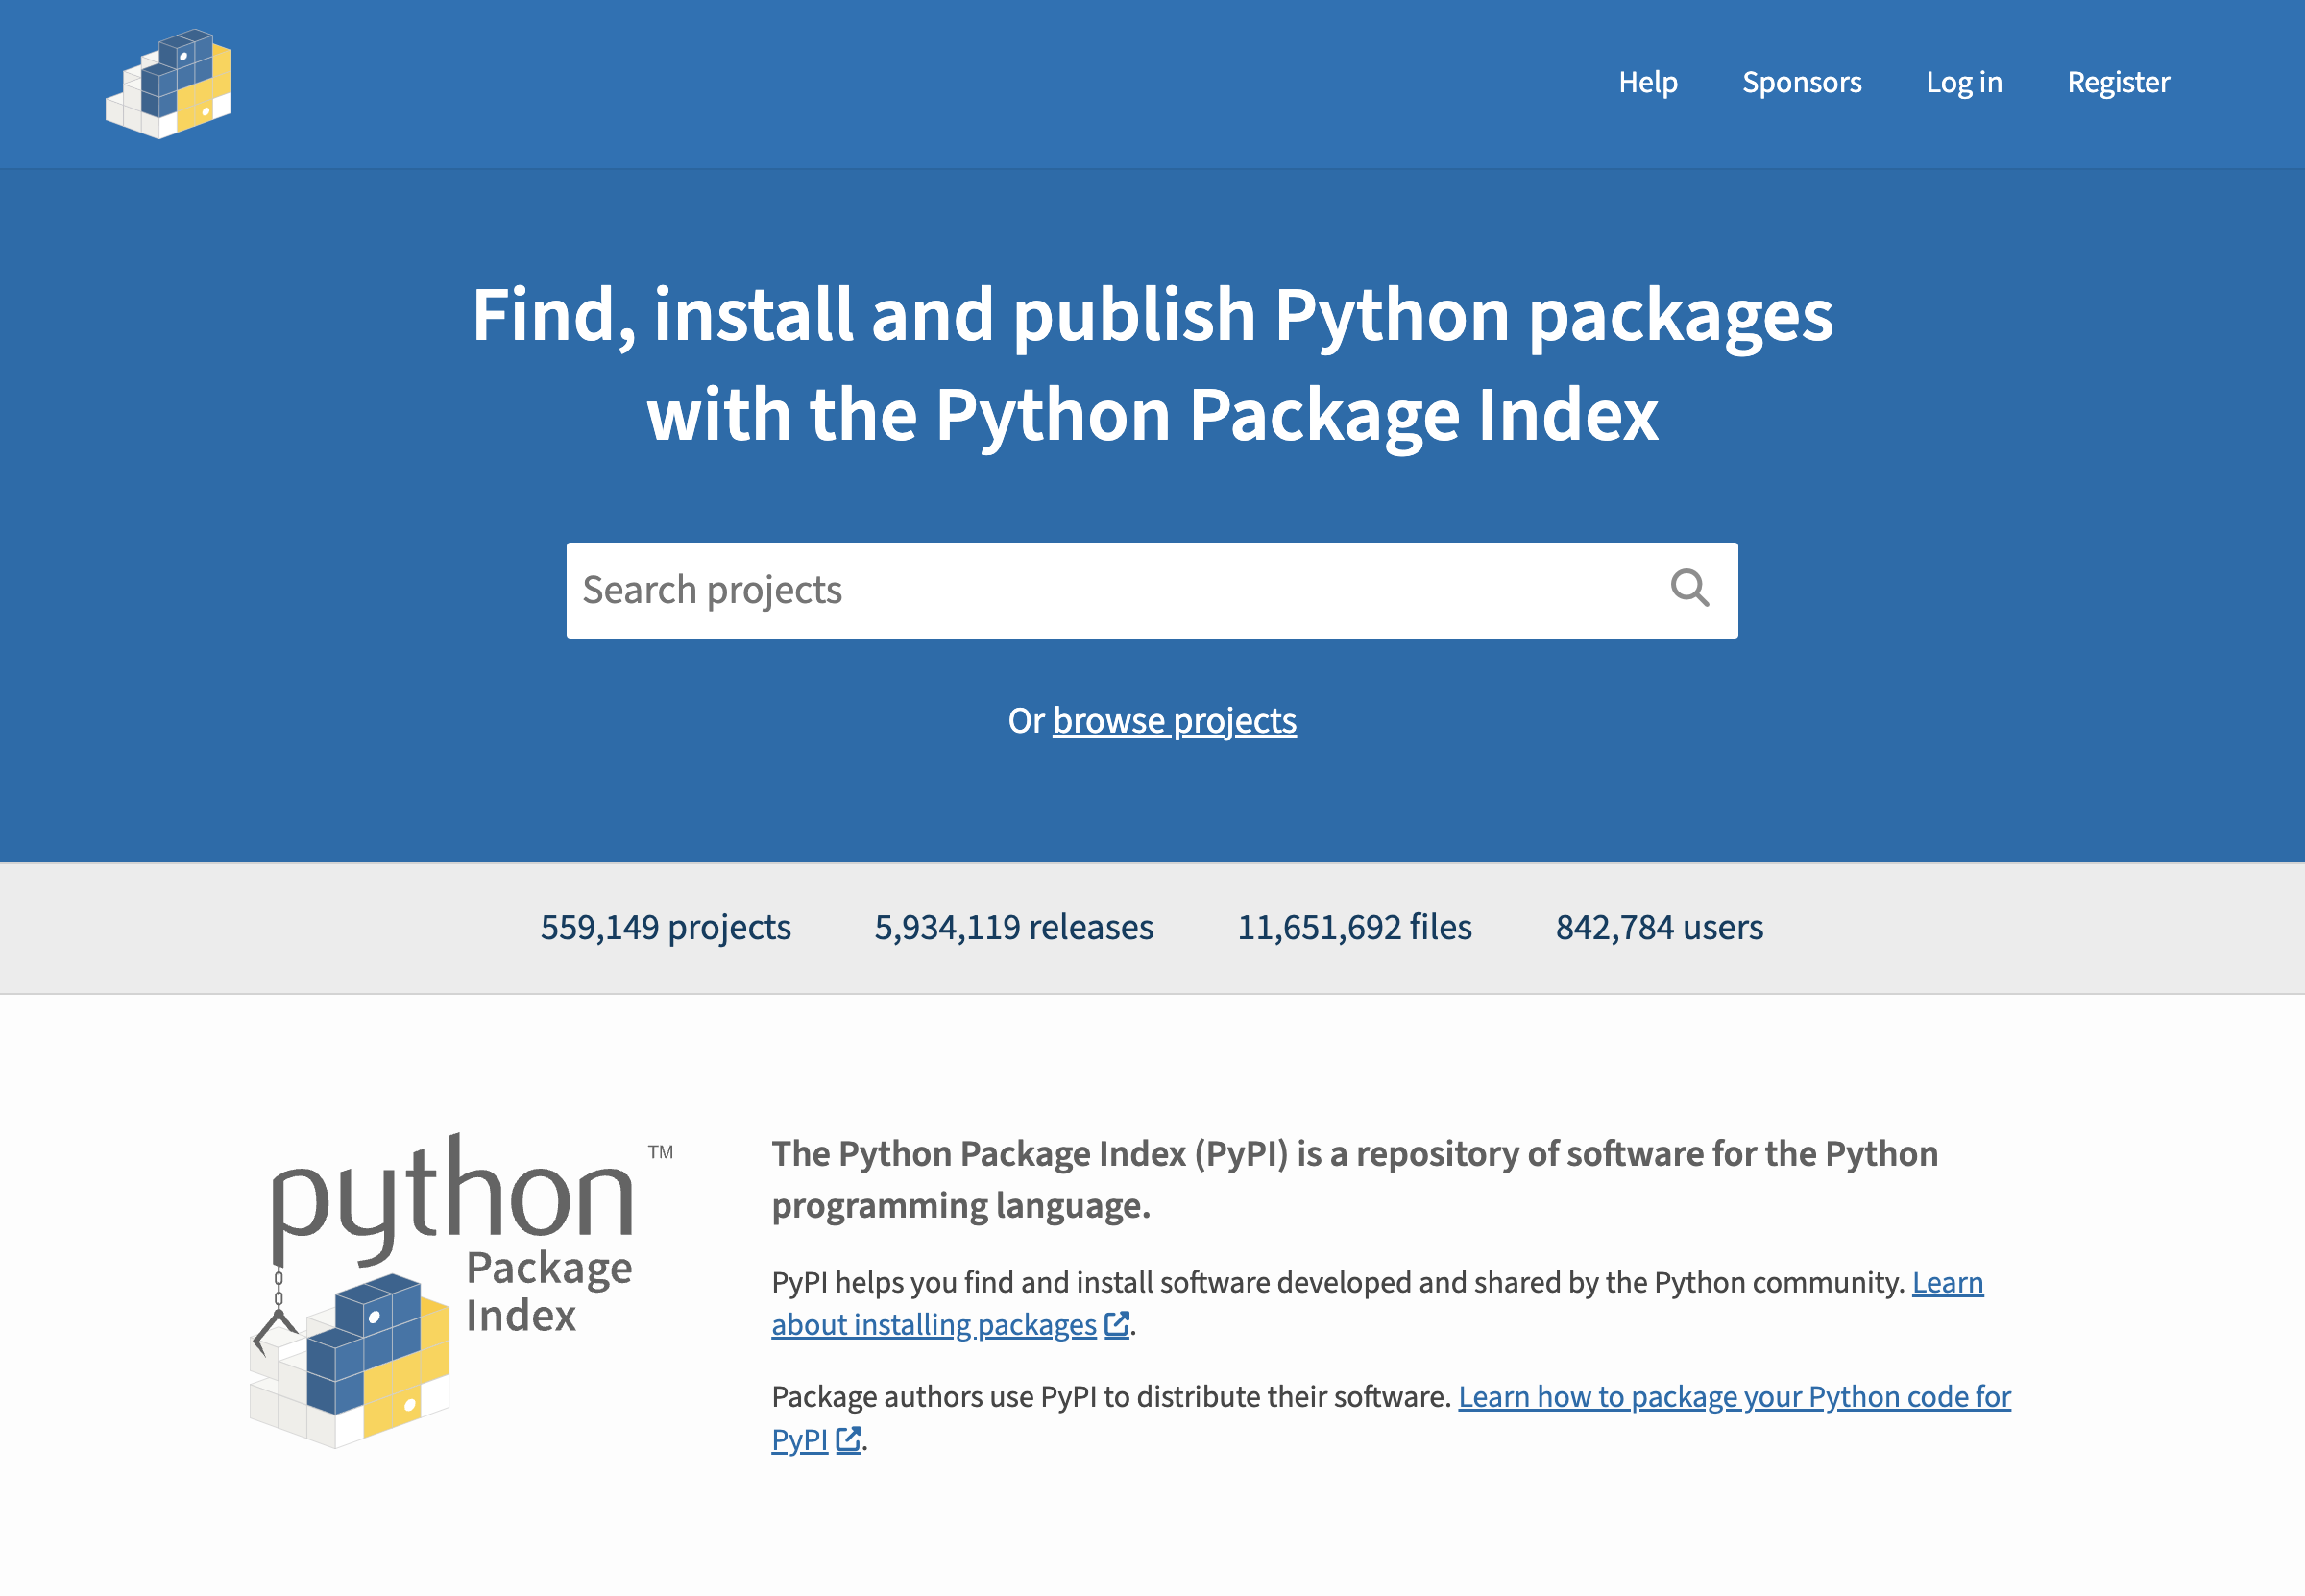

In [4]:
driver.get('https://pypi.org')

# Switch to the english page for results consistency
driver.add_cookie({'name': '_LOCALE_', 'value': 'en'})
driver.refresh()

screenshot(driver)

## DOM interactions

The main idea behind the page object model is to use simple Pythonic code to interact with your page. Python classes, with their attributes, will be used to describe an HTML page. Each class will inherit from a Manen `Component`, in order to symbolize the fact that they should be related to the DOM of the current page.

Each class attributes must be annotated with the type of DOM value you want to retrieve, as long as the selectors used to locate the elements. Manen provides some types to represent basic DOM elements; you can also use the type `str` (to extract the inner text of an element), `int` or `datetime` to attempt to convert the text to the given types. Note that you can use `element` or Selenium WebElement to return the raw Selenium web element.

In [5]:
from typing import Annotated

from manen.page_object_model.types import href, input_value, src
from manen.page_object_model.config import CSS, XPath
from manen.page_object_model.component import Form, Page, Component


class NavigationBar(Component):
    class NavigationMenuItem(Component):
        label: Annotated[str, CSS("a.horizontal-menu__link")]
        link: Annotated[href, CSS("a.horizontal-menu__link")]

    logo: Annotated[src, CSS("a.site-header__logo img")]
    items: Annotated[list[NavigationMenuItem], CSS("ul li.horizontal-menu__item")]


class PyPIHomePage(Page):
    class SearchForm(Form):
        query: Annotated[input_value, CSS("input[name='q']")]

    navbar: Annotated[NavigationBar, CSS("header.site-header")]
    search: Annotated[SearchForm, CSS("form.search-form")]

A page is initialized using the driver instance.

In [6]:
page = PyPIHomePage(driver)

You can now access each one of the DOM values as attributes of the page or component you created.

In [7]:
print(page.navbar.logo)

https://pypi.org/static/images/logo-small.8998e9d1.svg


Each component provides a method `model_dump` to serialize all the attributes into a dictionary.

In [8]:
page.navbar.model_dump()

{'logo': 'https://pypi.org/static/images/logo-small.8998e9d1.svg',
 'items': [{'label': 'Help', 'link': 'https://pypi.org/help/'},
  {'label': 'Sponsors', 'link': 'https://pypi.org/sponsors/'},
  {'label': 'Log in', 'link': 'https://pypi.org/account/login/'},
  {'label': 'Register', 'link': 'https://pypi.org/account/register/'}]}

Filling the value of the input with the search query is done with an assignment.

In [9]:
page.search.query = "selenium"

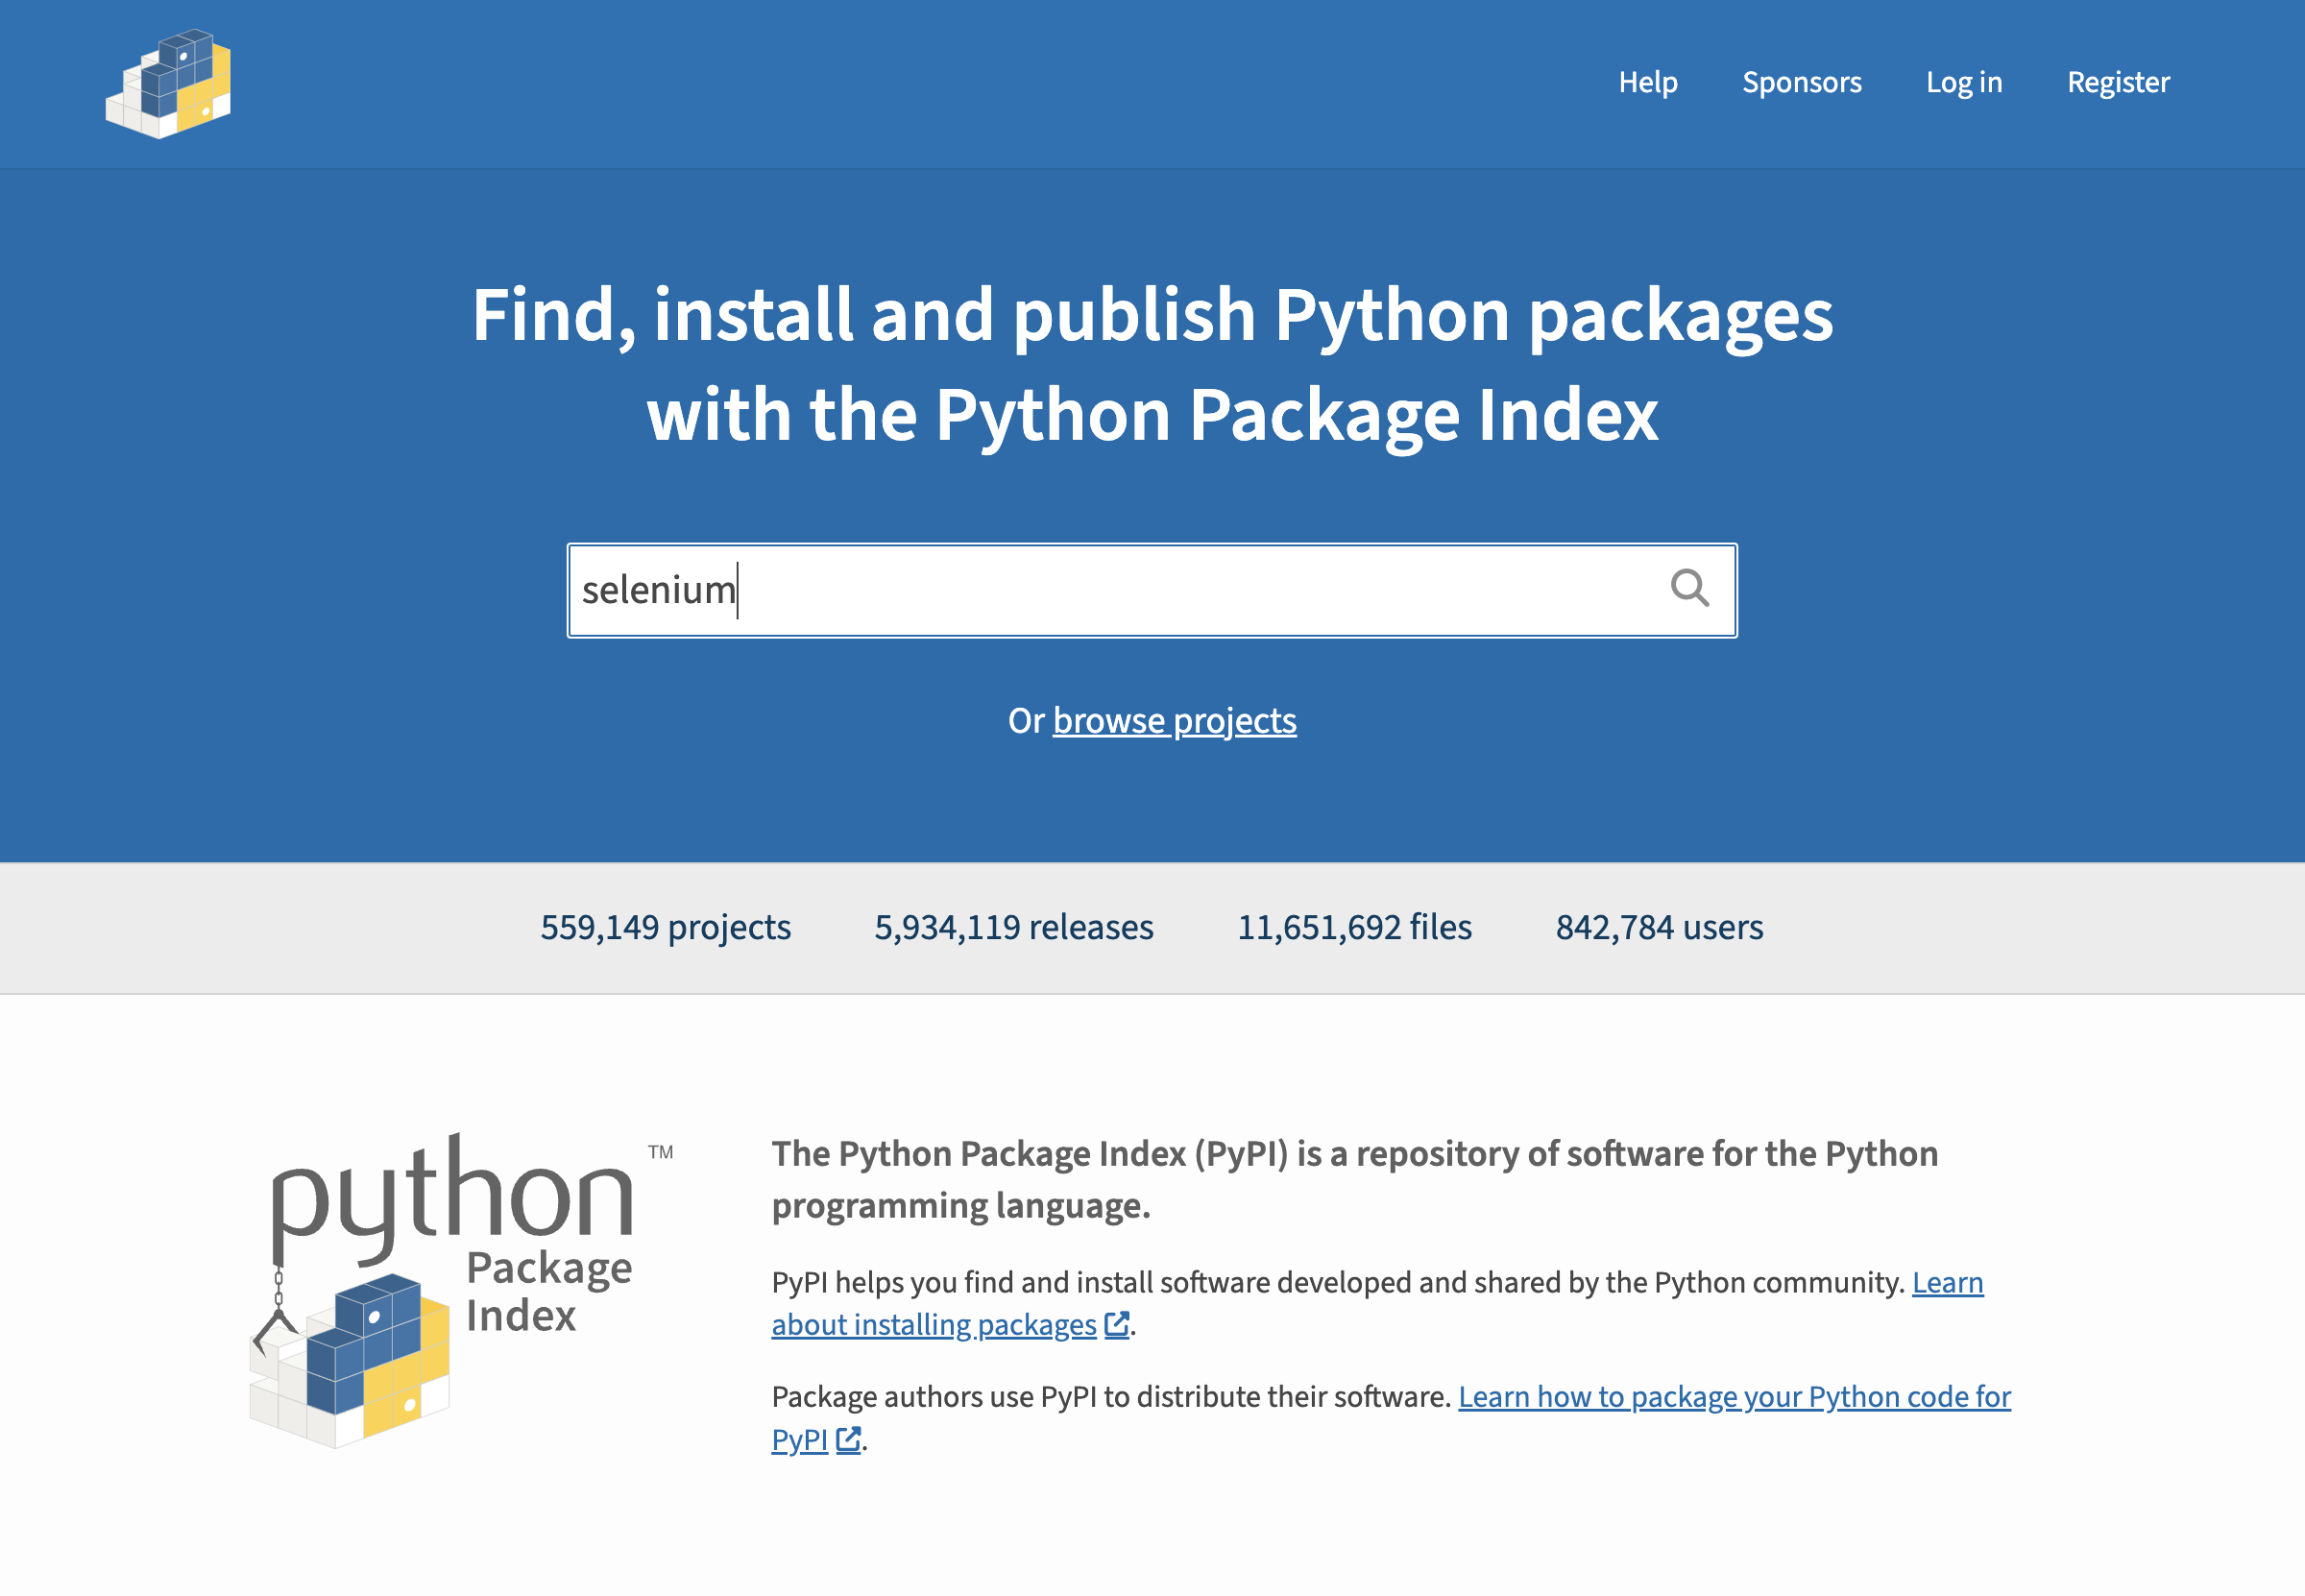

In [10]:
screenshot(driver)

Given that `page.search` inherit from the `Form` class, it has an additional method `submit` compared to other component, you can call to submit the query. Note that it can also be done with the following instructions:

```python
from selenium.webdriver.common.keys import Keys

page.search.query += Keys.ENTER
```

In [11]:
page.search.submit()

By doing so, we navigated to another page, with the results of the search.

Current URL: https://pypi.org/search/?q=selenium


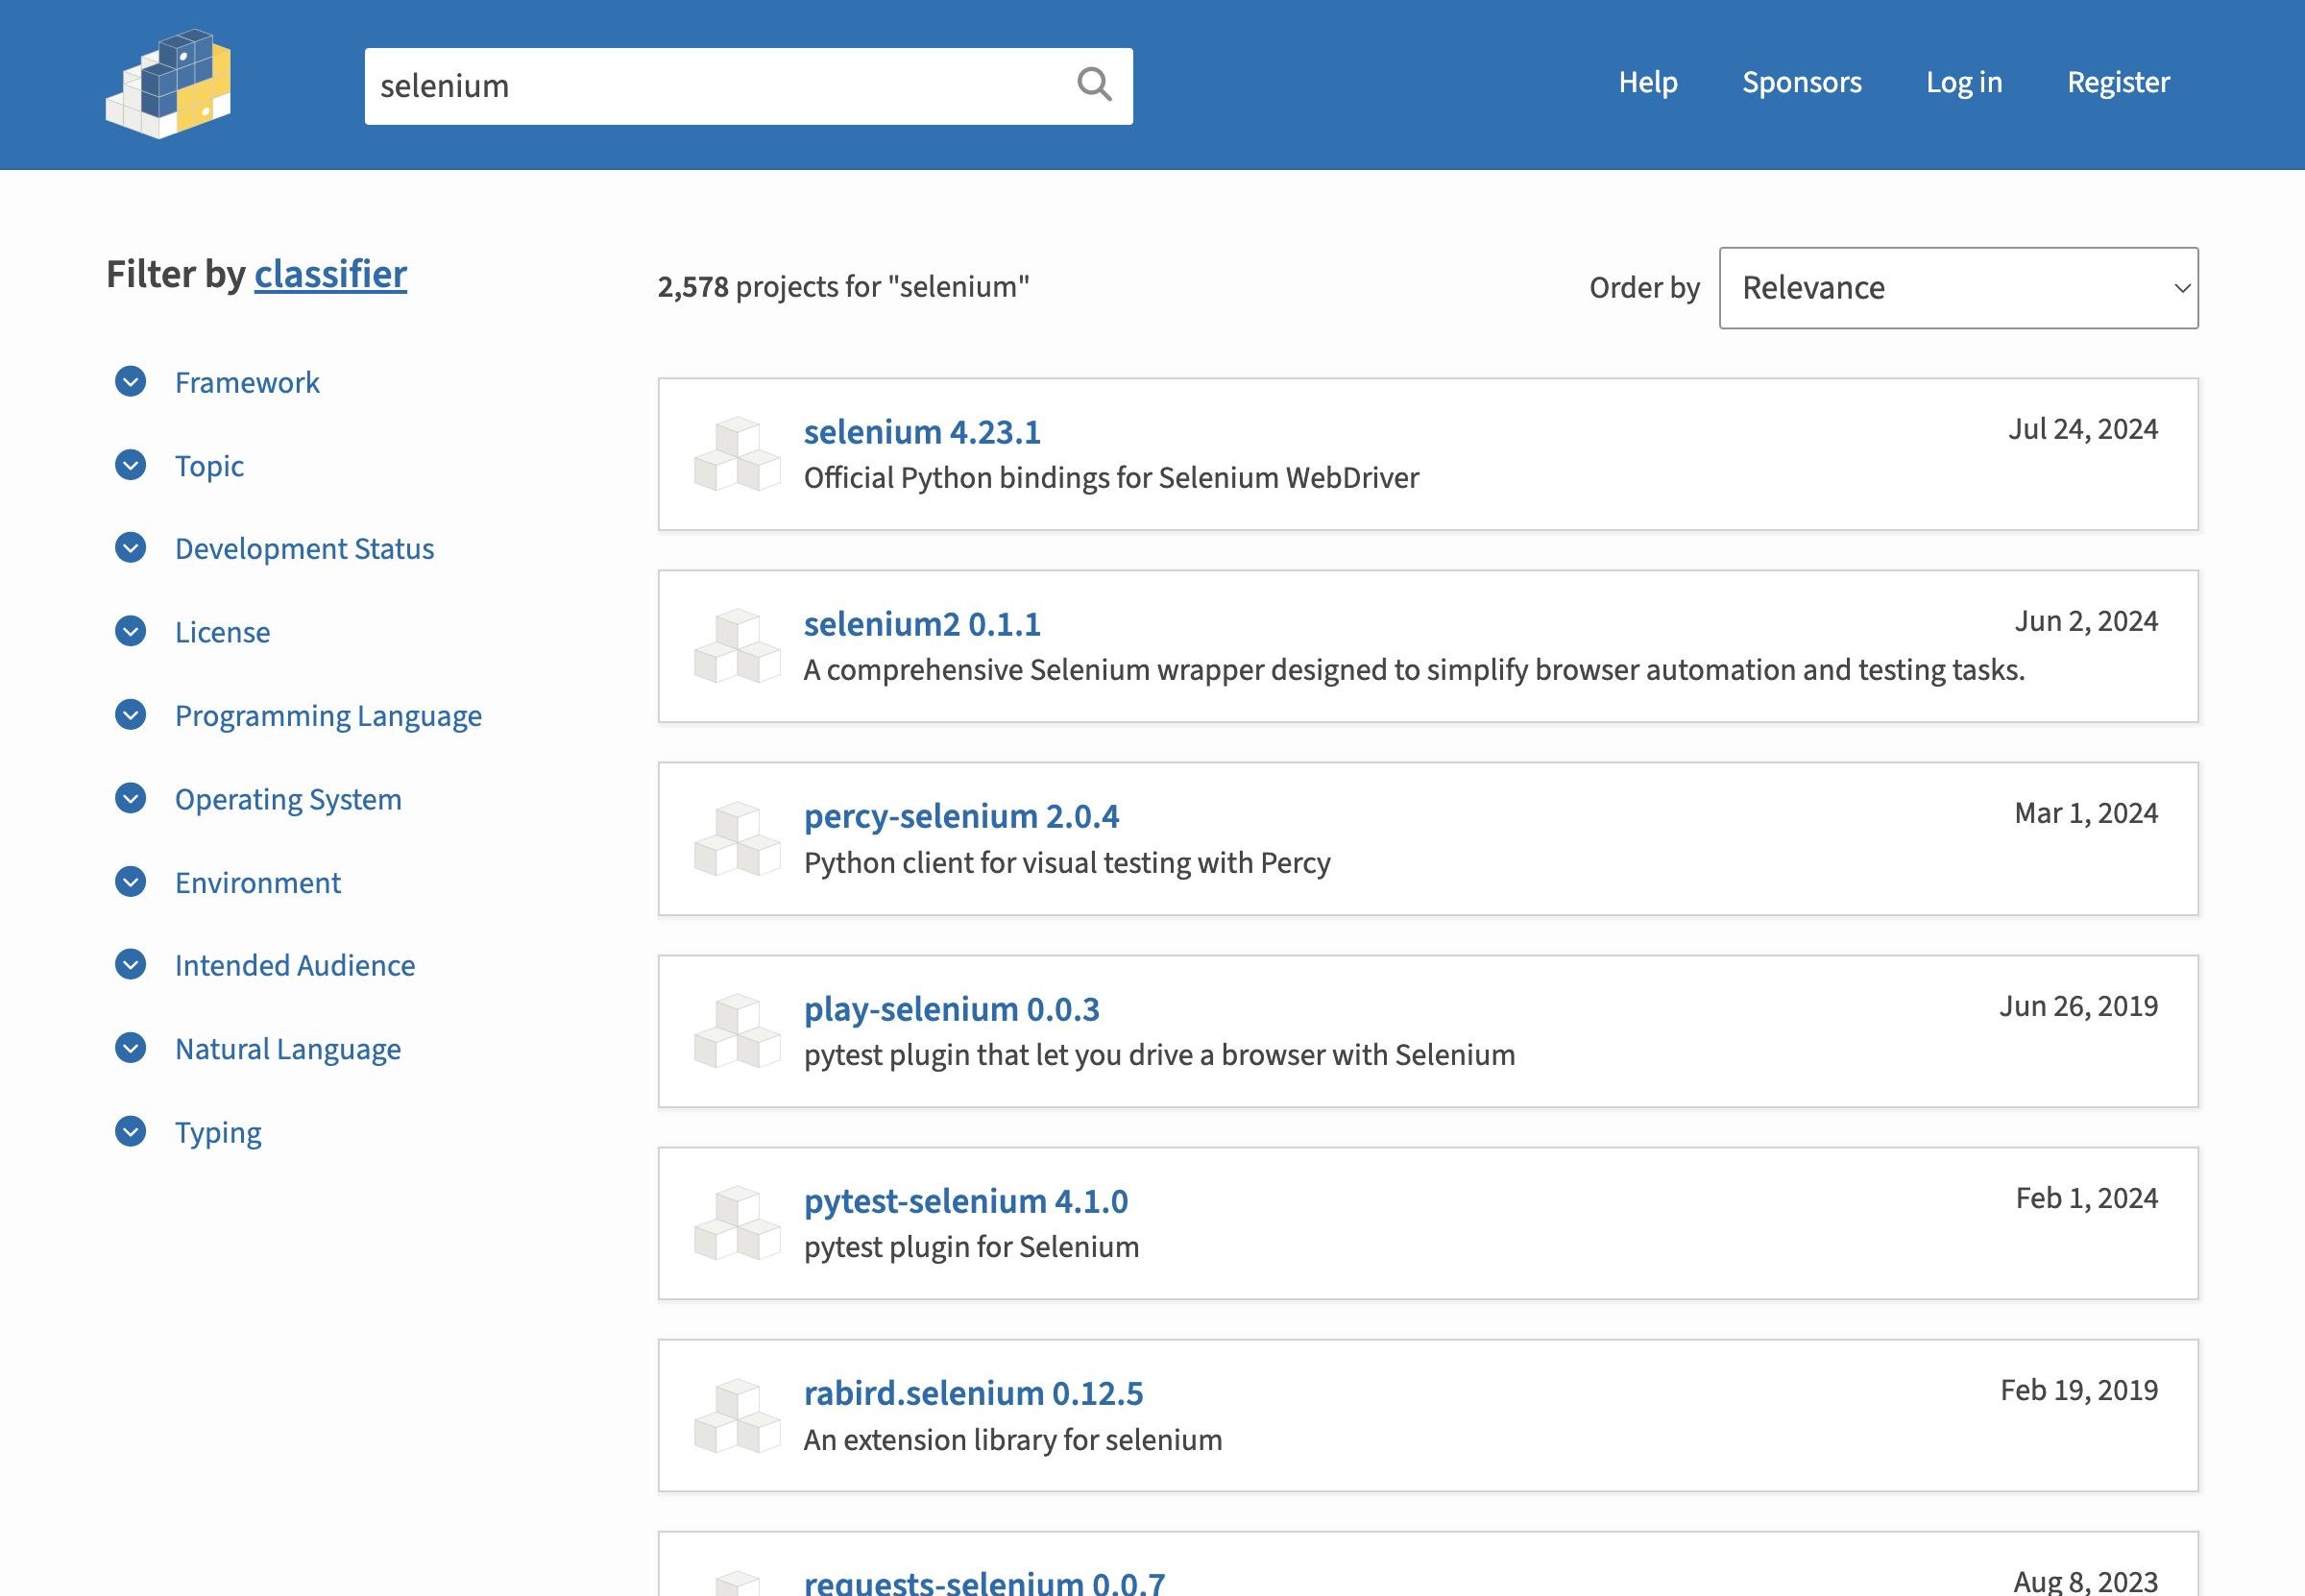

In [12]:
print('Current URL:', driver.current_url)
screenshot(driver)

Let's define another page class to describe the new HTML structure. Notice that we re-use the class `NavigationBar` given that this web component is also on the current page.

In [13]:
from datetime import datetime, timedelta


class SearchResultPage(Page):
    class Result(Component):
        name: Annotated[str, CSS("h3 span.package-snippet__name")]
        version: Annotated[str, CSS("h3 span.package-snippet__version")]
        link: Annotated[href, CSS("a.package-snippet")]
        description: Annotated[str, CSS("p.package-snippet__description")]
        release_date: Annotated[datetime, CSS("span.package-snippet__created")]

        @property
        def is_recent(self):
            return self.release_date >= datetime.now() - timedelta(days=180)

        def print_summary(self):
            summary = f"{self.name} (v{self.version}) has been released on {self.release_date.date()}"
            if self.is_recent:
                summary += ", less than 180 days ago"
            print(summary)

    navbar: Annotated[NavigationBar, CSS("header.site-header")]

    nb_results_label: Annotated[
        str,
        XPath("//*[@id='content']//form/div[1]/div[1]/p/strong"),
    ]
    results: Annotated[
        list[Result],
        CSS("ul[aria-label='Search results'] li"),
    ]

In [14]:
page = SearchResultPage(driver)

In [15]:
print("Number of results for the query:", page.nb_results_label)
print("Number of results on the page:", len(page.results))

Number of results for the query: 2578
Number of results on the page: 20


Same as before, we can access the elemens of the navigation bar.

In [16]:
page.navbar.model_dump()

{'logo': 'https://pypi.org/static/images/logo-small.8998e9d1.svg',
 'items': [{'label': 'Help', 'link': 'https://pypi.org/help/'},
  {'label': 'Sponsors', 'link': 'https://pypi.org/sponsors/'},
  {'label': 'Log in', 'link': 'https://pypi.org/account/login/'},
  {'label': 'Register', 'link': 'https://pypi.org/account/register/'}]}

Besides, all the search results of the page will be on each item of `page.results`.

In [17]:
page.results[0].model_dump()

{'name': 'selenium',
 'version': '4.23.1',
 'link': 'https://pypi.org/project/selenium/',
 'description': 'Official Python bindings for Selenium WebDriver',
 'release_date': datetime.datetime(2024, 7, 24, 0, 0)}

> Note that `model_dump` doesn't include custom properties in the dictionary.

We can then call the custom method `print_summary` we implemented for `Result` item.

In [18]:
for result in page.results[:5]:
    result.print_summary()

selenium (v4.23.1) has been released on 2024-07-24, less than 180 days ago
selenium2 (v0.1.1) has been released on 2024-06-02, less than 180 days ago
percy-selenium (v2.0.4) has been released on 2024-03-01, less than 180 days ago
play-selenium (v0.0.3) has been released on 2019-06-26
pytest-selenium (v4.1.0) has been released on 2024-02-01


## List of available Manen types

Manen implements out of the box the current elements:

| Type          | Description                                                         |
|---------------|---------------------------------------------------------------------|
| `checkbox`    | Form element to interact with a checkbox through boolean assignment |
| `datetime`    | Extract the inner text of an element, and parse it to a datetime    |
| `element`     | Return the raw Selenium element                                     |
| `href`        | Extract the `href` attribute of an element                          |
| `inner_html`  | Extract the inner HTML of an element                                |
| `input_value` | Form element to interact with an input                              |
| `int`         | Convert the inner text of an element to an integer                  |
| `float`       | Convert the inner text of an element to a float                     |
| `outer_html`  | Extract the outer HTML of an element                                |
| `src`         | Extract the `src` attribute of an element                           |
| `str`         | Extract the inner text of an element                                |


> The list of types provided by Manen intends to grow to cover a maximum of use cases.

## Advanced usage

The page object implementation is using internally the `find` function, which has additional arguments to customize how to retrieve elements from the DOM (see [associated user guide](https://kodaho.github.io/manen/user_guide/dom_exploration.html) for more details about that). In the same way, you can add options to each class attributes to enable this level of customization in your page model.

Waiting a given duration for element to appear is done with the `Wait` config, whereas ` Default` is used to set a default value when the element behind a DOM value is not found.

In [19]:
from manen.page_object_model.config import Default, Wait

class SearchResultPage(Page):
    nb_results_label: Annotated[
        str,
        XPath("//*[@id='content']//form/div[1]/div[1]/p/strong"),
        Wait(5),
    ]

    dont_exist: Annotated[str | None, CSS('i-dont-exist'), Default(None)]

page = SearchResultPage(driver)

In [20]:
assert page.dont_exist is None

Note that when using a default value, the type specified in the annotation should be coherent with the default value, with the restriction that only not-None type is allowed. For example, you can't have something like `Annotated[int | str, CSS('i-dont-exist'), Default('not here')]`.

---

You are now familiar with the page object model implementation of Manen! Don't hesitate to [open an issue](https://github.com/kodaho/manen/issues) if you have any remarks, concerns, or feature request!

In [21]:
driver.quit()